# Logistic regression and neural network models for analyzing real world data
## Kaida Ning

### Our Dataset: 
Notes and description from doctors.
### Approach:
We assume that we have readmission information and build prototypes for predicting readmission risk using logistic regression and neural network.

In [17]:
import keras
import nltk
import pandas as pd
import numpy as np
import re
import io

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
#upload file to process
from google.colab import files 
uploaded = files.upload()


Saving data_cardiovascular.csv to data_cardiovascular.csv


In [19]:
questions = pd.read_csv(io.BytesIO(uploaded['data_cardiovascular.csv']),encoding='utf-8') 
questions.head()

,Merged_notes_description,readmission,class_label
0,"2-D M-MODE: , ,1. Left atrial enlargement wit...",no,0
1,1. The left ventricular cavity size and wall ...,no,0
2,"2-D ECHOCARDIOGRAM,Multiple views of the heart...",readmission,1
3,"DESCRIPTION:,1. Normal cardiac chambers size....",readmission,1
4,"HISTORY OF PRESENT ILLNESS: , I was kindly ask...",readmission,1


### Inspect the data

#Use regular expressions to clean up pour data, and save it back to disk for future use

In [20]:
def standardize_text(df, text_field):
  df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
  df[text_field] = df[text_field].str.replace(r",", " ")
  df[text_field] = df[text_field].str.lower()
  return df




In [21]:
questions = standardize_text(questions, "Merged_notes_description")
questions
questions.to_csv("/content/drive/My Drive/clean_data.csv")


In [5]:
clean_questions = pd.read_csv("/content/drive/My Drive/clean_data.csv")
clean_questions.head()

,Unnamed: 0,Merged_notes_description,readmission,class_label
0,0,2 d m mode 1 left atrial enlargement wit...,no,0
1,1,1 the left ventricular cavity size and wall ...,no,0
2,2,2 d echocardiogram multiple views of the heart...,readmission,1
3,3,description 1 normal cardiac chambers size ...,readmission,1
4,4,history of present illness i was kindly ask...,readmission,1


### Data Overview

In [22]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')


clean_questions["tokens"] = clean_questions["Merged_notes_description"].apply(tokenizer.tokenize)
clean_questions
clean_questions.groupby("class_label").count()


,Unnamed: 0,Merged_notes_description,readmission,tokens
class_label,,,,
0,54,54,54,54
1,50,50,50,50


### Data preparation
- Tokenizing sentences to a list of separate words
- Creating a train test split
- Inspecting our data a little more to validate results

### Inspecting our dataset a little more

In [ ]:
clean_questions["tokens"]

0      [2, d, m, mode, 1, left, atrial, enlargement, ...
1      [1, the, left, ventricular, cavity, size, and,...
2      [2, d, echocardiogram, multiple, views, of, th...
3      [description, 1, normal, cardiac, chambers, si...
4      [history, of, present, illness, i, was, kindly...
                             ...                        
99     [title, of, procedure, coronary, artery, bypas...
100    [preoperative, diagnosis, coronary, occlusive,...
101    [subjective, the, patient, states, that, she, ...
102    [diagnosis, aortic, valve, stenosis, with, cor...
103    [indication, chest, pain, type, of, test, aden...
Name: tokens, Length: 104, dtype: object

In [7]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

all_words = [word for tokens in clean_questions["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in clean_questions["tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

33913 words total, with a vocabulary size of 3386
Max sentence length is 1019


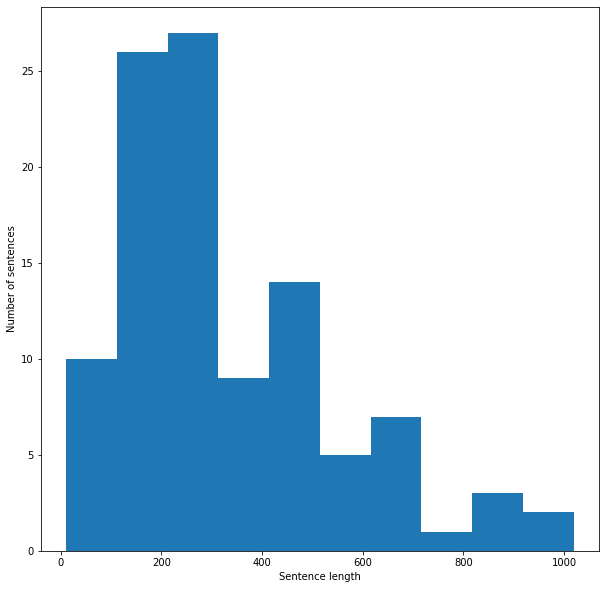

In [8]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths)
plt.show()

## Modeling

## Enter embeddings
We use a bag of words model, and apply a logistic regression on top.

## Bag of Words Counts

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def cv(data):
    count_vectorizer = CountVectorizer()

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

list_corpus = clean_questions["Merged_notes_description"].tolist()
list_labels = clean_questions["class_label"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=40)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

### Visualizing the embeddings by projecting them down to 2.

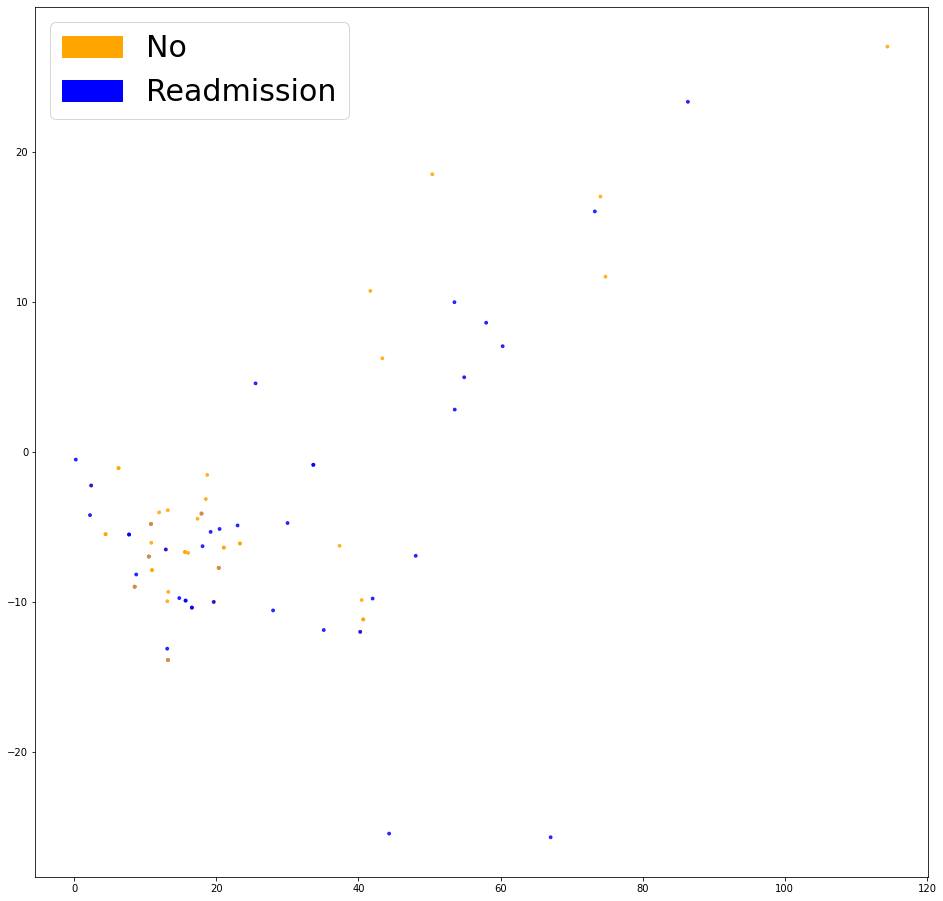

In [10]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='No')
            green_patch = mpatches.Patch(color='blue', label='Readmission')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 30})


fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_counts, y_train)
plt.show()

### Fitting a classifier
Starting with a logistic regression is a good idea. It is simple, often gets the job done, and is easy to interpret.

In [14]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)

In [ ]:
type(X_train_counts)

scipy.sparse.csr.csr_matrix

### Evaluation


In [15]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.667, precision = 0.747, recall = 0.667, f1 = 0.667


### Inspection
Visualize the confusion matrix.

In [11]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

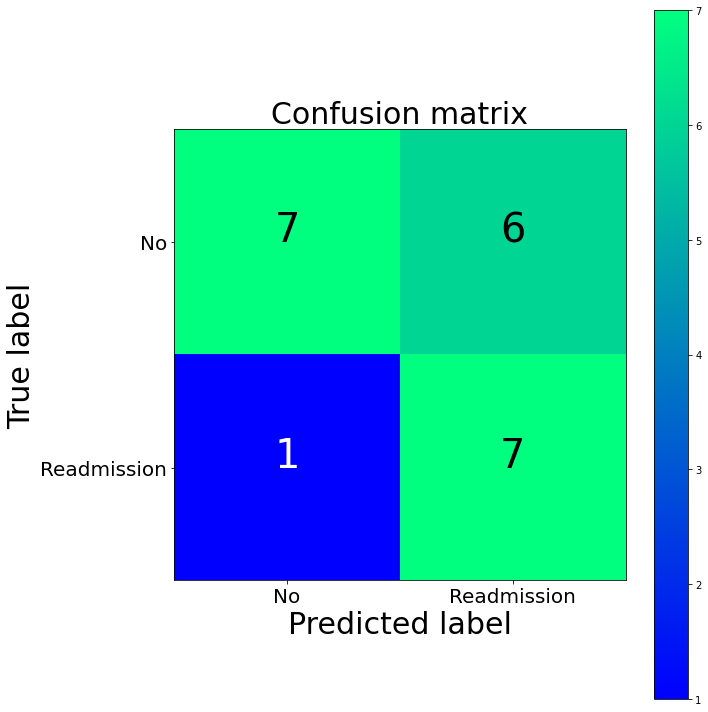

[[7 6]
 [1 7]]


In [16]:
cm = confusion_matrix(y_test, y_predicted_counts)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['No','Readmission'], normalize=False, title='Confusion matrix')
plt.show()
print(cm)

###  word2vec
Word2vec is a model that was pre-trained on a very large corpus, and provides embeddings that map words that are similar close to each other. A quick way to get a sentence embedding for our classifier, is to average word2vec scores of all words in our sentence.

In [ ]:
import gensim


In [ ]:
word2vec_path = "/content/drive/My Drive/Colab Notebooks/NLP/data/GoogleNews-vectors-negative300.bin.gz"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [ ]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_questions, generate_missing=False):
    embeddings = clean_questions['tokens'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

In [ ]:
embeddings = get_word2vec_embeddings(word2vec, clean_questions)
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(embeddings, list_labels, 
                                                                                        test_size=0.2, random_state=40)

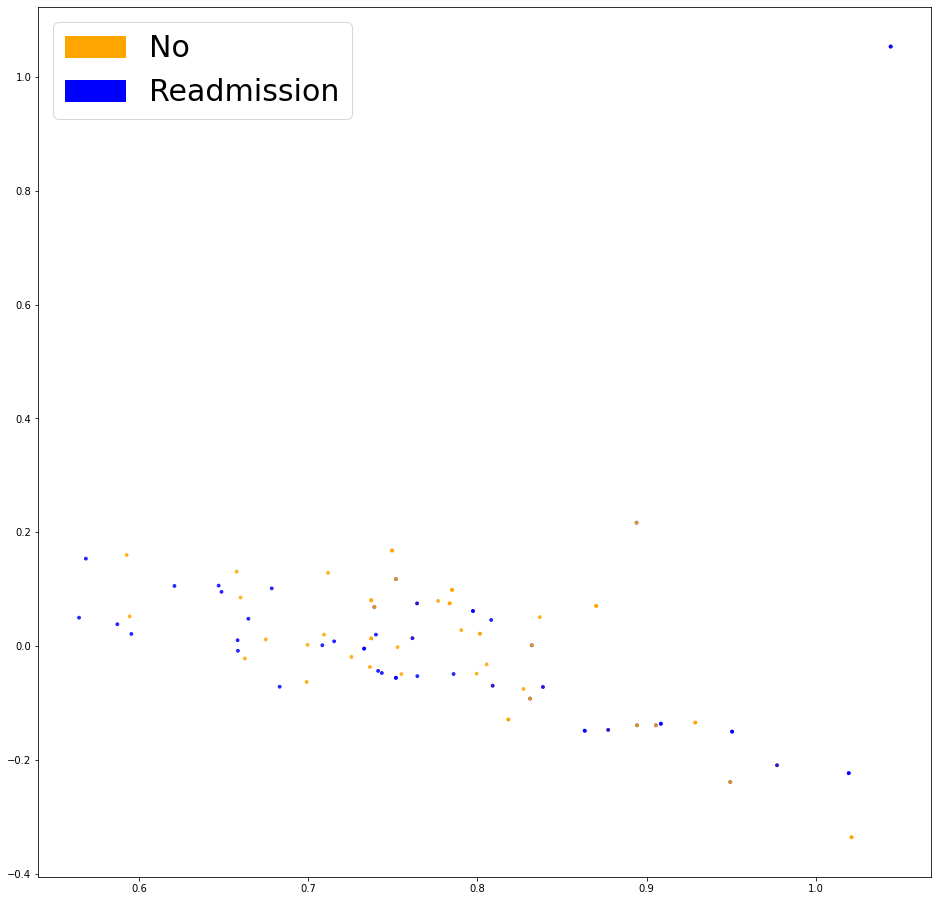

In [ ]:
fig = plt.figure(figsize=(16, 16))          
plot_LSA(embeddings, list_labels)
plt.show()



### CNNs for text classification
Here, we will be using a Convolutional Neural Network for sentence classification.

First, let's embed our text!

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

EMBEDDING_DIM = 300
MAX_SEQUENCE_LENGTH = 35
VOCAB_SIZE = len(VOCAB)

VALIDATION_SPLIT=.2
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(clean_questions["Merged_notes_description"].tolist())
sequences = tokenizer.texts_to_sequences(clean_questions["Merged_notes_description"].tolist())

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

cnn_data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = to_categorical(np.asarray(clean_questions["class_label"]))

indices = np.arange(cnn_data.shape[0])
np.random.shuffle(indices)
cnn_data = cnn_data[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * cnn_data.shape[0])

embedding_weights = np.zeros((len(word_index)+1, EMBEDDING_DIM))
for word,index in word_index.items():
    embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(embedding_weights.shape)

Found 3384 unique tokens.
(3385, 300)


In [ ]:
clean_questions

,Unnamed: 0,Merged_notes_description,readmission,class_label,tokens
0,0,2 d m mode 1 left atrial enlargement wit...,no,0,"[2, d, m, mode, 1, left, atrial, enlargement, ..."
1,1,1 the left ventricular cavity size and wall ...,no,0,"[1, the, left, ventricular, cavity, size, and,..."
2,2,2 d echocardiogram multiple views of the heart...,readmission,1,"[2, d, echocardiogram, multiple, views, of, th..."
3,3,description 1 normal cardiac chambers size ...,readmission,1,"[description, 1, normal, cardiac, chambers, si..."
4,4,history of present illness i was kindly ask...,readmission,1,"[history, of, present, illness, i, was, kindly..."
...,...,...,...,...,...
99,99,title of procedure coronary artery bypass g...,no,0,"[title, of, procedure, coronary, artery, bypas..."
100,100,preoperative diagnosis coronary occlusive d...,readmission,1,"[preoperative, diagnosis, coronary, occlusive,..."
101,101,subjective the patient states that she feel...,readmission,1,"[subjective, the, patient, states, that, she, ..."
102,102,diagnosis aortic valve stenosis with corona...,no,0,"[diagnosis, aortic, valve, stenosis, with, cor..."


Now, we will define a simple Convolutional Neural Network

In [ ]:
import keras
from keras.layers.merge import concatenate
from keras.layers import Dense, Input, Flatten, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.layers import LSTM, Bidirectional
from keras.models import Model

def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index, trainable=False, extra_conv=True):
    
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=trainable)

    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    # Yoon Kim model (https://arxiv.org/abs/1408.5882)
    convs = []
    filter_sizes = [3,4,5]

    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=128, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = MaxPooling1D(pool_size=3)(l_conv)
        convs.append(l_pool)

    l_merge = concatenate(convs, axis=1)

    # add a 1D convnet with global maxpooling, instead of Yoon Kim model
    conv = Conv1D(filters=128, kernel_size=3, activation='relu')(embedded_sequences)
    pool = MaxPooling1D(pool_size=3)(conv)

    if extra_conv==True:
        x = Dropout(0.5)(l_merge)  
    else:
        # Original Yoon Kim model
        x = Dropout(0.5)(pool)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    #x = Dropout(0.5)(x)

    preds = Dense(labels_index, activation='softmax')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])

    return model

Train our Neural Network

In [ ]:
x_train = cnn_data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = cnn_data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

model = ConvNet(embedding_weights, MAX_SEQUENCE_LENGTH, len(word_index)+1, EMBEDDING_DIM, 
                len(list(clean_questions["class_label"].unique())), False)

In [ ]:
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=3, batch_size=128)

Epoch 1/3
1/1 [==============================] - 0s 251ms/step - loss: 0.7978 - acc: 0.4405 - val_loss: 0.7149 - val_acc: 0.5000
Epoch 2/3
1/1 [==============================] - 0s 27ms/step - loss: 0.5400 - acc: 0.6905 - val_loss: 0.8253 - val_acc: 0.5000
Epoch 3/3
1/1 [==============================] - 0s 27ms/step - loss: 0.4323 - acc: 0.8452 - val_loss: 0.8688 - val_acc: 0.5500
